In [1]:
import numpy as np
import h5py

#f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
#              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
#              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
#              +",FALSE,1/deeplift.imp_score.h5", "r")
f = h5py.File("deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [2]:
f_null = h5py.File("null.deeplift.imp_score.h5","r")
null_nanog_profile_wn_hypimp = np.array(f_null["hyp_imp/Nanog/profile/wn"][:])
null_onehot_seq = np.array(f_null["inputs/seq"][:])
null_nanog_profile_wn_contribs = null_nanog_profile_wn_hypimp*null_onehot_seq

In [3]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [4]:
null_nanog_profile_wn_contribs.shape

(4816, 1000, 4)

In [5]:
nanog_per_position_contrib_scores = np.sum(nanog_profile_wn_contribs, axis=-1)
null_per_position_contrib_scores = np.sum(null_nanog_profile_wn_contribs, axis=-1)

In [6]:
from importlib import reload
import modisco
reload(modisco.coordproducers)

vw_perc_transformer = modisco.coordproducers.VariableWindowWidthPercentileTransform([7,11,15,21])
vw_perc_transformer.fit(score_track=nanog_per_position_contrib_scores,
                        null_track=null_per_position_contrib_scores)

TF-MoDISco is using the TensorFlow backend.
/users/avanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/avanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/avanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/avanti/anaconda3/lib/python3

Fitting - on window size 7
Computing window sums
Done computing window sums
Subsampling!
Subsampling!
Fitting - on window size 11
Computing window sums
Done computing window sums
Subsampling!
Subsampling!
Fitting - on window size 15
Computing window sums
Done computing window sums
Subsampling!
Subsampling!
Fitting - on window size 21
Computing window sums
Done computing window sums
Subsampling!
Subsampling!


In [7]:
(vw_prectransformed_contrib_scores,
 vw_prectransformed_windowindices) = vw_perc_transformer.transform(
                                      nanog_per_position_contrib_scores)

In [8]:
np.sum(np.isnan(vw_prectransformed_contrib_scores))

0

(array([42695052.,        0.,        0.,  3370654.,        0.,        0.,
         3516232.,        0.,        0.,  5651062.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

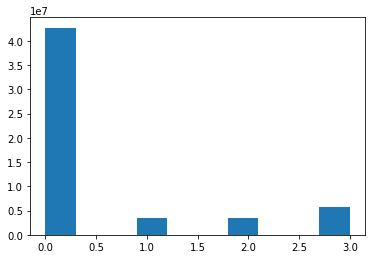

In [10]:
from matplotlib import pyplot as plt
plt.hist(np.array(vw_prectransformed_windowindices).ravel())

(array([2.5086000e+04, 4.9047000e+04, 1.5127300e+05, 1.3135000e+05,
        1.5354110e+06, 7.3206610e+06, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 3.3140800e+05, 0.0000000e+00,
        0.0000000e+00, 2.0000000e+00, 3.7912497e+07, 2.9440520e+06,
        1.9311180e+06, 1.4119410e+06, 1.1522140e+06, 3.3694000e+05]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

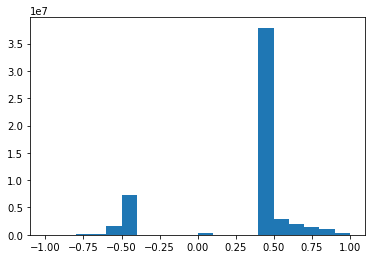

In [11]:
from matplotlib import pyplot as plt

plt.hist(np.concatenate(vw_prectransformed_contrib_scores, axis=0), bins=20)

In [26]:
def percentile_transform(vals):
    vals = np.nan_to_num(np.array(vals))
    return modisco.util.convert_to_percentiles(vals.ravel()).reshape(vals.shape)


In [13]:
perctransformed_vw_prectransformed_contrib_scores = percentile_transform(vw_prectransformed_contrib_scores)

In [14]:
from importlib import reload
import modisco
reload(modisco.coordproducers)

FIXED_SLIDING_WINDOW_SIZE = 21
window_sum_function = modisco.coordproducers.get_simple_window_sum_function(
    window_size=FIXED_SLIDING_WINDOW_SIZE)
fixed_window_sums_fg = np.array(window_sum_function(nanog_per_position_contrib_scores))
fixed_window_sums_bg = np.array(window_sum_function(null_per_position_contrib_scores))
fw_ir_pos, fw_ir_neg, _, _ = modisco.coordproducers.get_isotonic_regression_classifier(
                                orig_vals=fixed_window_sums_fg.ravel(),
                                null_vals=fixed_window_sums_bg.ravel())


Subsampling!
Subsampling!


In [27]:
perctransformed_fw_contrib_scores = percentile_transform(fixed_window_sums_fg)

In [28]:
perctransformed_vw_prectransformed_contrib_scores.shape

(55233, 1000)

In [32]:
perctransformed_fw_contrib_scores.shape

(55233, 980)

In [33]:
cmp_perctransformed_vw_prectransformed_contrib_scores = perctransformed_vw_prectransformed_contrib_scores[:,10:-10]
cmp_vw_prectransformed_windowindices = np.array(vw_prectransformed_windowindices)[:,10:-10]
cmp_vw_prectransformed_contrib_scores = np.array(vw_prectransformed_contrib_scores)[:,10:-10]


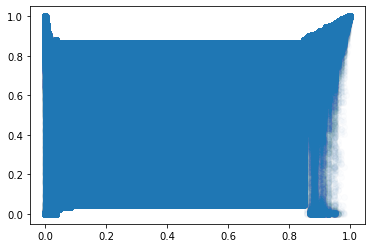

In [34]:
plt.scatter(cmp_perctransformed_vw_prectransformed_contrib_scores.ravel(),
            perctransformed_fw_contrib_scores.ravel(),
            alpha=0.01)
plt.show()

In [35]:
maxinslidingwindow_perctransformed_fw_contrib_scores =\
    modisco.util.sliding_window_max(a=perctransformed_fw_contrib_scores,
                                    window=FIXED_SLIDING_WINDOW_SIZE)
maxinslidingwindow_cmp_perctransformed_vw_prectransformed_contrib_scores =\
    modisco.util.sliding_window_max(a=cmp_perctransformed_vw_prectransformed_contrib_scores,
                                    window=FIXED_SLIDING_WINDOW_SIZE)

In [66]:
UPPER_THRESH = 0.97
LOWER_THRESH = 0.97
missed_by_fw = np.nonzero((cmp_perctransformed_vw_prectransformed_contrib_scores[:,10:-10] >= UPPER_THRESH)
 *(maxinslidingwindow_perctransformed_fw_contrib_scores <= LOWER_THRESH))
missed_by_vw = np.nonzero((perctransformed_fw_contrib_scores[:,10:-10] >= UPPER_THRESH)
 *(maxinslidingwindow_cmp_perctransformed_vw_prectransformed_contrib_scores <= LOWER_THRESH))

50138
6004


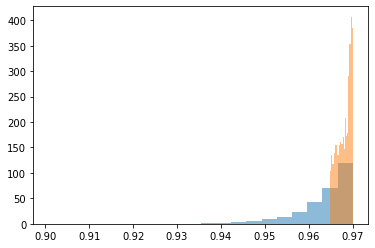

In [86]:
print(len(missed_by_fw[0]))
plt.hist(maxinslidingwindow_perctransformed_fw_contrib_scores[missed_by_fw],
         bins=20, alpha=0.5, density=True)
print(len(missed_by_vw[0]))
plt.hist(maxinslidingwindow_cmp_perctransformed_vw_prectransformed_contrib_scores[missed_by_vw],
         bins=20, alpha=0.5, density=True)
plt.show()

6 560 0.9772313653069723 0.9656743953352347 2


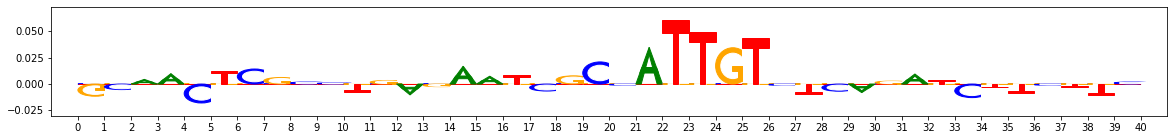

6 561 0.9726098165951514 0.9656743953352347 0


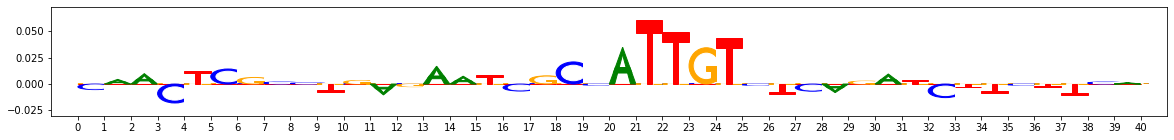

6 562 0.9790366628645918 0.9656743953352347 0


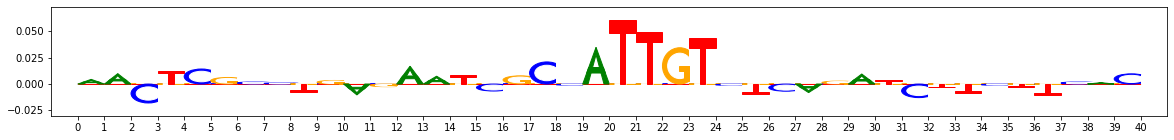

8 555 0.9790368077055384 0.9525821593642073 2


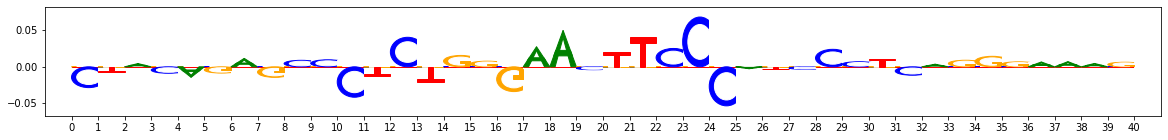

15 513 0.9772317274093386 0.9611498708439978 0


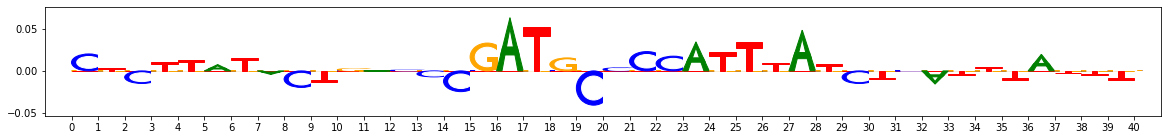

15 514 0.9708763601470135 0.9611498708439978 0


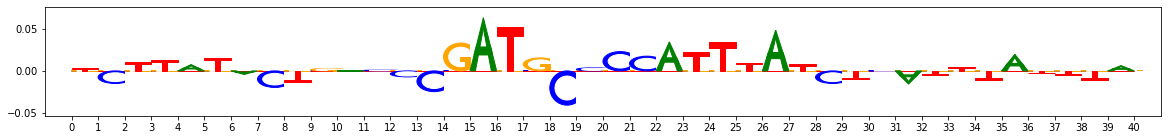

15 515 0.9708763782521319 0.9611498708439978 0


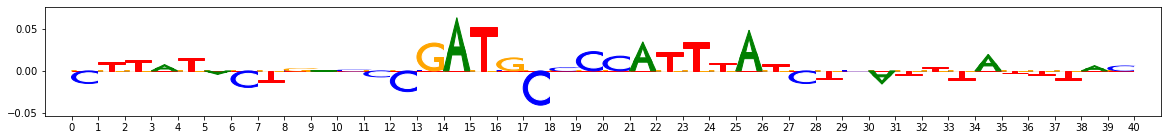

19 535 0.9708764325674868 0.967645433057803 0


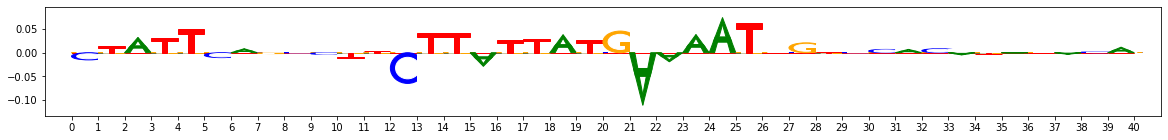

22 582 0.9708765230930784 0.9670889408394937 3


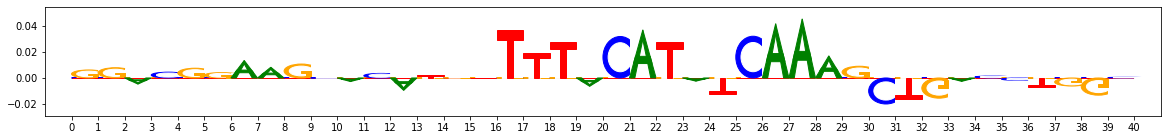

22 583 0.9708765411981968 0.9670889408394937 3


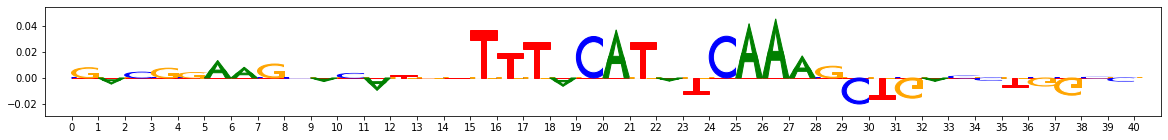

22 584 0.9708765593033151 0.9670889408394937 3


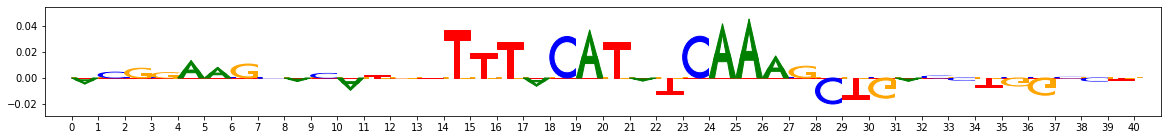

22 585 0.9708765774084334 0.9670889408394937 2


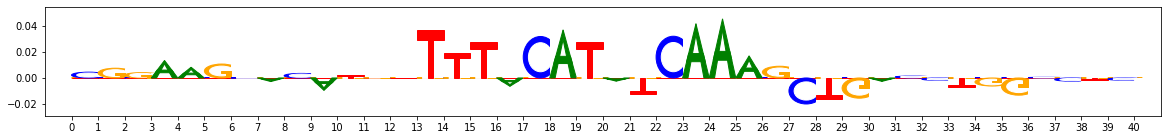

26 540 0.9772321800372965 0.9563815738668505 0


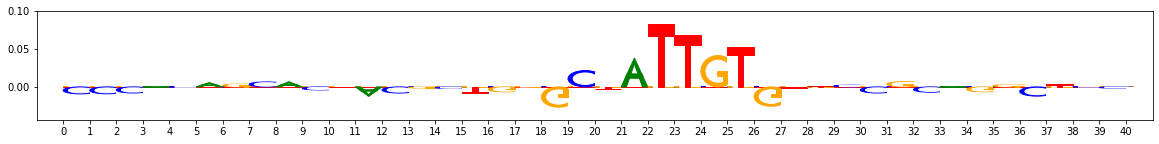

26 542 0.9832110513642207 0.9563815738668505 0


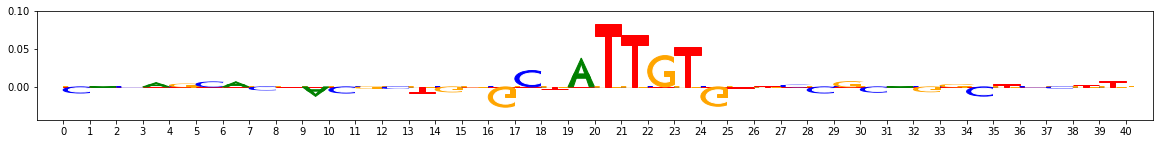

26 543 0.9790374413846794 0.9563815738668505 0


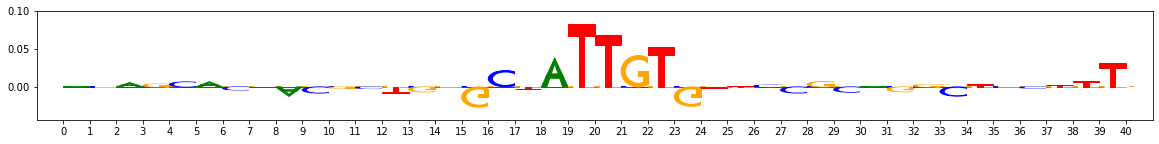

26 544 0.9790374594897978 0.9563815738668505 1


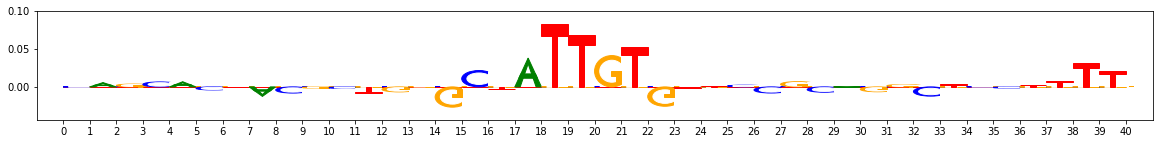

26 545 0.9726099976463346 0.9563815738668505 1


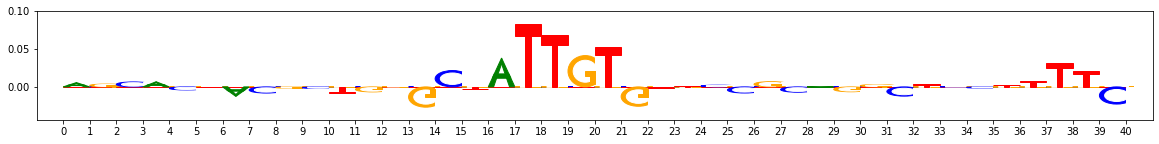

26 546 0.9772321981424149 0.9563815738668505 1


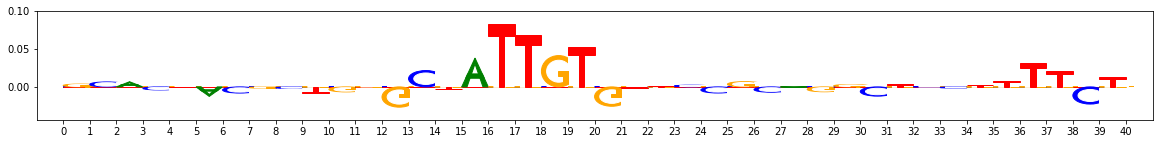

33 536 0.9790378215921641 0.9682580880921159 0


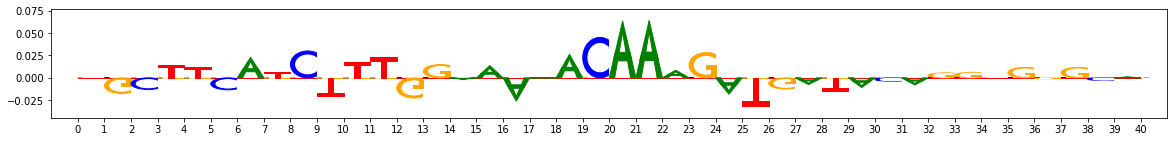

37 571 0.9772327956113194 0.9684736867969718 0


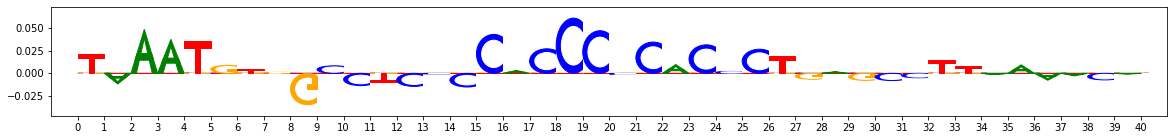

In [69]:
from modisco.visualization import viz_sequence

for i in range(20):
    seqidx,col = missed_by_fw[0][i], missed_by_fw[1][i]
    flank = 10
    vw_window_size_here = vw_prectransformed_windowindices[seqidx][40+col]
    print(seqidx, col,
          cmp_perctransformed_vw_prectransformed_contrib_scores[:,10:-10][seqidx,col],
          maxinslidingwindow_perctransformed_fw_contrib_scores[seqidx,col],
          vw_window_size_here)
    viz_sequence.plot_weights(
        nanog_profile_wn_contribs[seqidx, col+10-flank:col+30+flank])

49 461 0.9707832348082354 0.9698528415983199 3


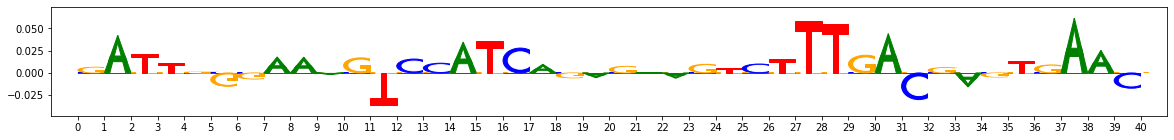

51 519 0.9725507377466222 0.9698529321239114 3


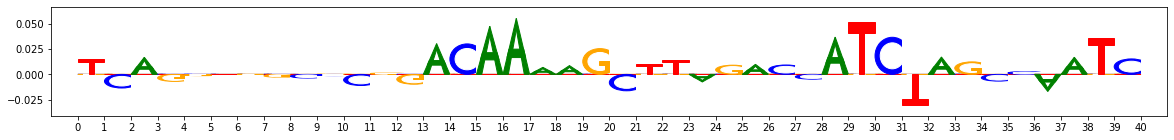

51 521 0.9720597749718539 0.9698529321239114 3


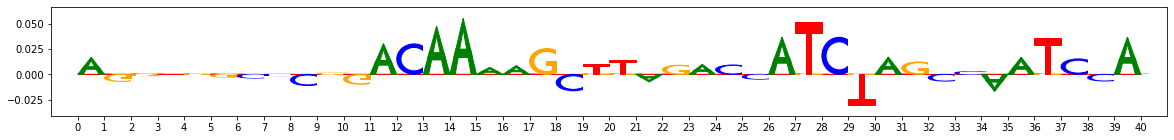

51 522 0.9753891584334565 0.9698529321239114 3


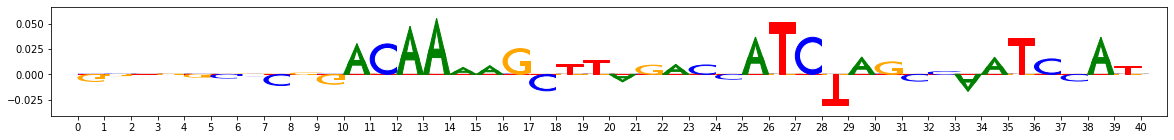

53 551 0.9707841215895407 0.9648091720529394 3


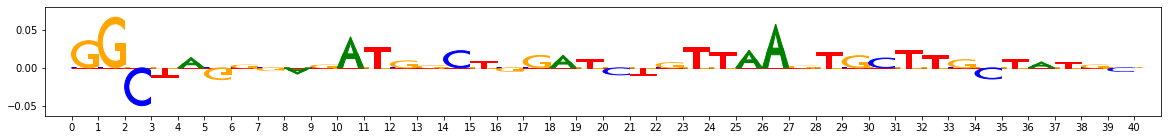

76 517 0.9724833054181968 0.9698535658030525 3


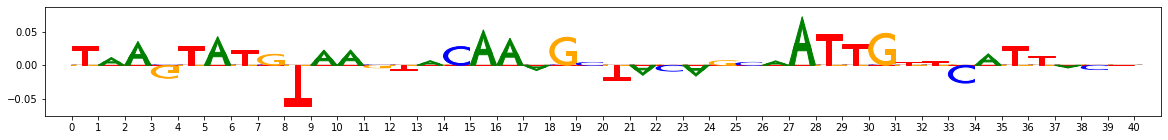

77 457 0.9711273613785311 0.969294298698242 1


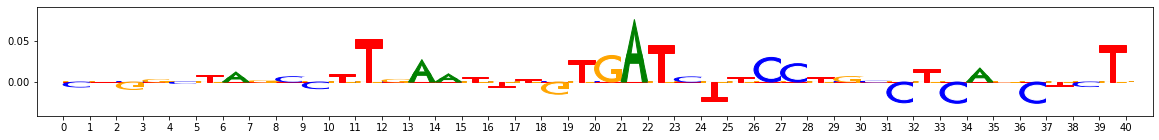

83 431 0.9705663983044741 0.9692944616443069 3


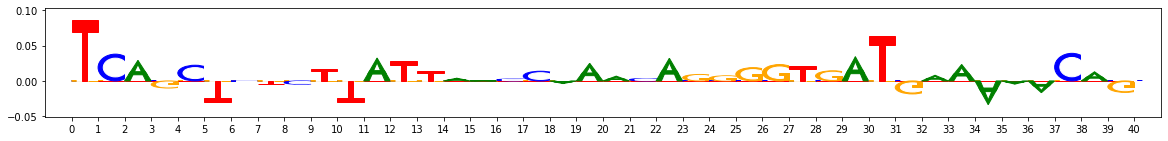

83 432 0.9725707826990445 0.9692944616443069 2


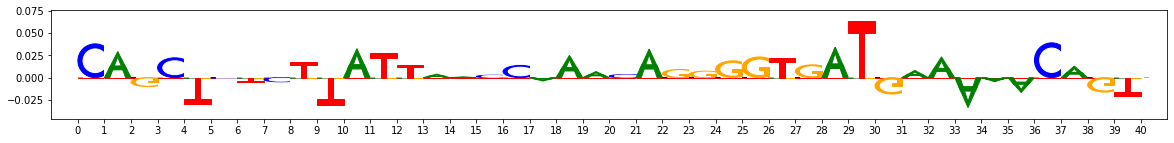

107 413 0.9726918098726102 0.9698543986384951 3


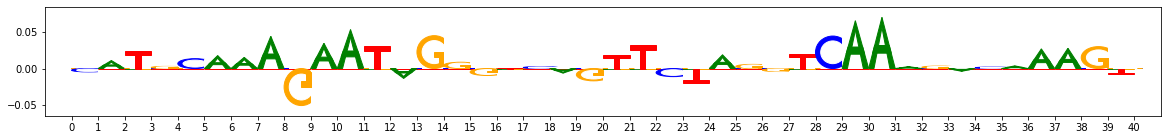

112 623 0.9712764699600985 0.9698546883203881 1


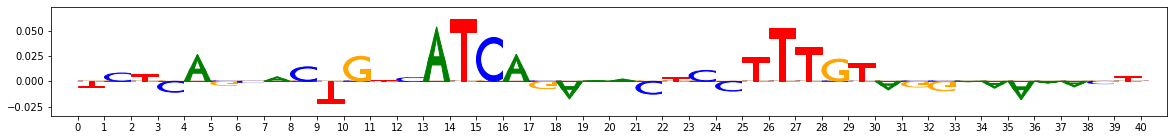

130 572 0.9705880874972335 0.969854959897163 3


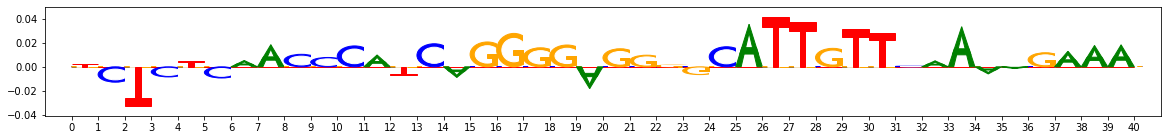

131 403 0.9758897280056991 0.9648173012510637 2


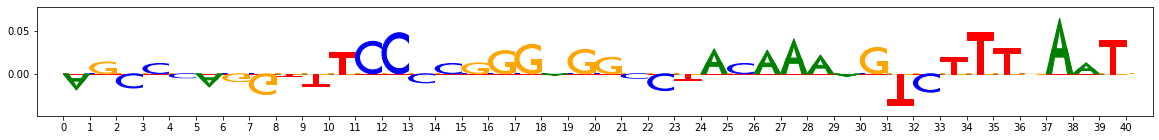

162 325 0.9707121814561467 0.969855593576304 2


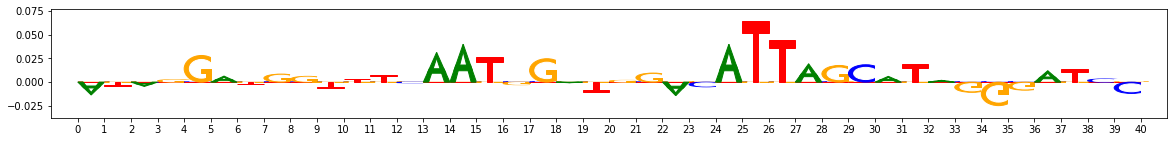

162 326 0.9731790961998834 0.969855593576304 0


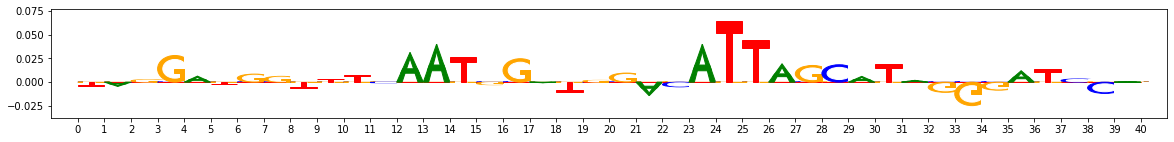

162 327 0.972215035598727 0.969855593576304 0


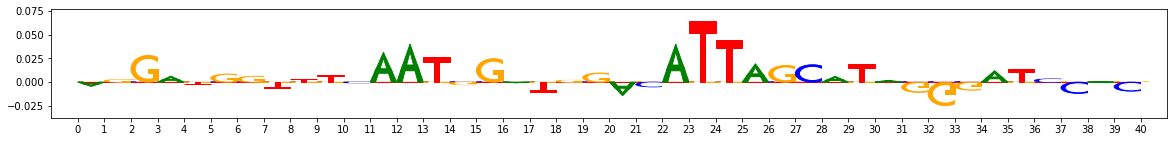

162 328 0.9705389635078409 0.969855593576304 0


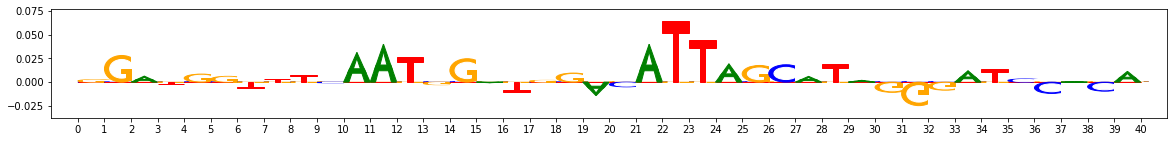

222 518 0.9717217080738112 0.9648258106566726 3


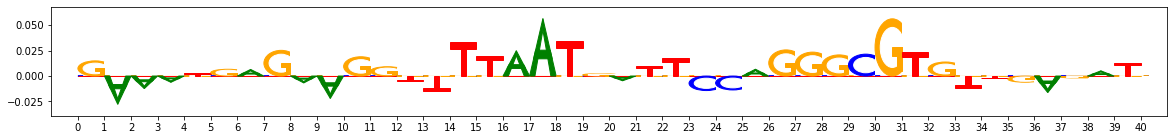

222 519 0.97240916680615 0.9648258106566726 0


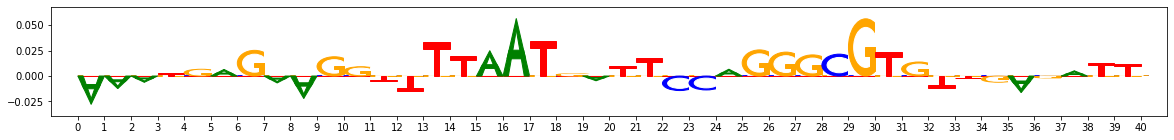

222 520 0.9731412417229126 0.9648258106566726 0


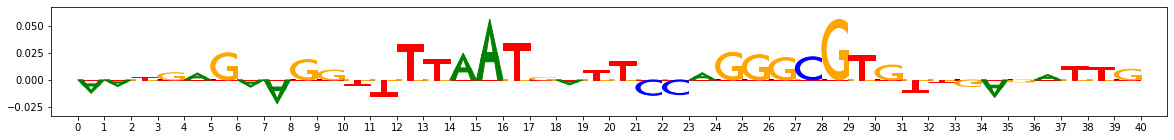

In [70]:
for i in range(20):
    seqidx,col = missed_by_vw[0][i], missed_by_vw[1][i]
    flank = 10
    vw_window_size_here = vw_prectransformed_windowindices[seqidx][40+col]
    print(seqidx, col,
          perctransformed_fw_contrib_scores[:,10:-10][seqidx,col],
          maxinslidingwindow_cmp_perctransformed_vw_prectransformed_contrib_scores[seqidx,col],
          vw_window_size_here)
    viz_sequence.plot_weights(
        nanog_profile_wn_contribs[seqidx, col+10-flank:col+30+flank])

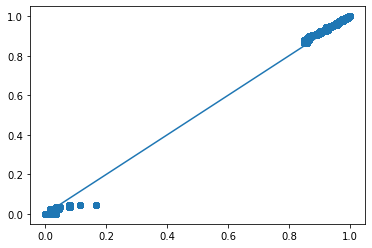

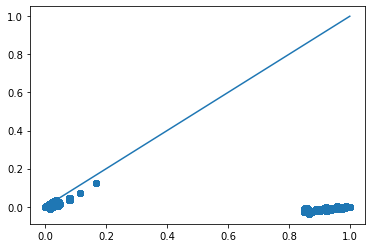

KeyboardInterrupt: 

In [72]:
plt.scatter(
    cmp_perctransformed_vw_prectransformed_contrib_scores[
        cmp_vw_prectransformed_windowindices == 3],
    perctransformed_fw_prectransformed_contrib_scores[
        cmp_vw_prectransformed_windowindices == 3]
    )
plt.plot([0,1], [0,1])
plt.show()

plt.scatter(
    cmp_vw_prectransformed_contrib_scores[
        cmp_vw_prectransformed_windowindices == 3],
    perctransformed_fw_prectransformed_contrib_scores[
        cmp_vw_prectransformed_windowindices == 3]
    )
plt.show()



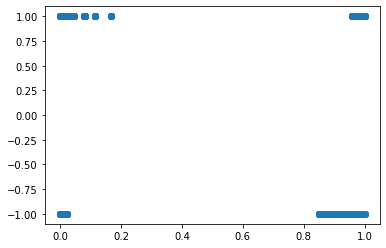

In [82]:
plt.scatter(
    cmp_perctransformed_vw_prectransformed_contrib_scores[
        cmp_vw_prectransformed_windowindices == 3],
    np.sign((cmp_perctransformed_vw_prectransformed_contrib_scores-
     perctransformed_fw_prectransformed_contrib_scores))[
        cmp_vw_prectransformed_windowindices == 3]
    )
plt.show()

In [74]:
debug_mask1 = ((cmp_vw_prectransformed_windowindices==3)
             *(cmp_perctransformed_vw_prectransformed_contrib_scores > 0.5)
             *(cmp_perctransformed_vw_prectransformed_contrib_scores
               > perctransformed_fw_prectransformed_contrib_scores))

debug_mask2 = ((cmp_vw_prectransformed_windowindices==3)
             *(cmp_perctransformed_vw_prectransformed_contrib_scores > 0.5)
             *(cmp_perctransformed_vw_prectransformed_contrib_scores
               < perctransformed_fw_prectransformed_contrib_scores))

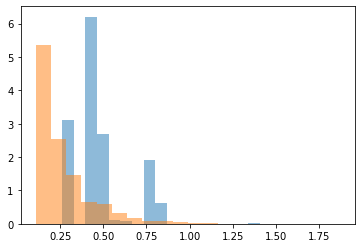

In [81]:
plt.hist(fixed_window_sums_fg[debug_mask1], bins=20, alpha=0.5, density=True)
plt.hist(fixed_window_sums_fg[debug_mask2], bins=20, alpha=0.5, density=True)
plt.show()